# Flux Balance Testing
Test that the measured fluxes are indeed balanced

In [1]:
%load_ext autoreload
%autoreload 2
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from os import path
from typing import List
from uncertainties import nominal_value, std_dev

import sys
sys.path.append(path.expanduser("~/git/flux-components/src"))

from flux_components.settings import (ureg, Q_, ComponentContribution, Reaction, ccache, R, default_T)
from flux_components.biomass_composition import BiomassComposition
from flux_components.flux_component_analysis import FluxComponentAnalysis
from flux_components.flux_sampler import FluxSampler

In [2]:
fca = FluxComponentAnalysis()

/usr/local/lib/python3.7/dist-packages/pint/quantity.py:1377 UnitStrippedWarning: The unit of the quantity is stripped.


## Test the flux balancing
This is important for us to be sure we use the correct biomass function, since most papers publish only the fluxes, but not the exact composition of the biomass (generally, it is growth-rate dependent and therefore the coefficients are not constants)

ERROR:root:There is no biomass function for 'e_coli_fiatflux'
ERROR:root:There is no biomass function for 'e_coli_fiatflux'
ERROR:root:There is no biomass function for 'e_coli_fiatflux'
ERROR:root:There is no biomass function for 'e_coli_fiatflux'
ERROR:root:There is no biomass function for 'e_coli_fiatflux'
ERROR:root:There is no biomass function for 'e_coli_fiatflux'
ERROR:root:There is no biomass function for 'e_coli_fiatflux'
/usr/local/lib/python3.7/dist-packages/pint/quantity.py:1377 UnitStrippedWarning: The unit of the quantity is stripped.


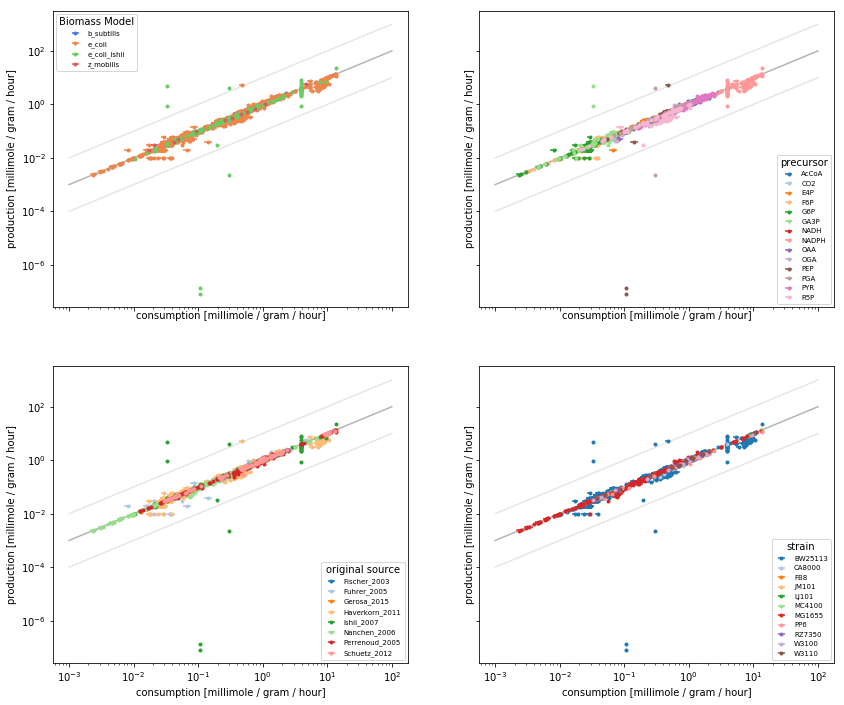

In [3]:
fig1 = fca.TestBiomassFunction()

## Compute the Principal Components based on random flux sampling

In [4]:
rxn_ignore = ['biomass', 'redox', 'respiration']

growth_rates = fca.rel_flux_df['biomass'].apply(lambda x: ureg.Quantity(x.nominal_value, "1/hour"))
f_meas = fca.rel_flux_df.drop(rxn_ignore, axis=1).applymap(nominal_value)

fsampler = FluxSampler()
fsampler.set_biomass_range(growth_rates.min(), growth_rates.max())
f_smpl = fsampler.multisample(1000, n_bins=10)

n_components = 4
decomposition = PCA(n_components)
decomposition.fit(f_smpl[f_meas.columns])
col_names = []
for i, var in enumerate(decomposition.explained_variance_ratio_):
    col_names.append(f"PCA #{i} ({var*100:.1f}%)")
decomp_df = pd.DataFrame(decomposition.components_.T,
                         index=f_meas.columns,
                         columns=col_names)
for r in rxn_ignore:
    decomp_df.loc[r, r] = 1
decomp_df = decomp_df.fillna(0)

### Plot the loadings of the first components

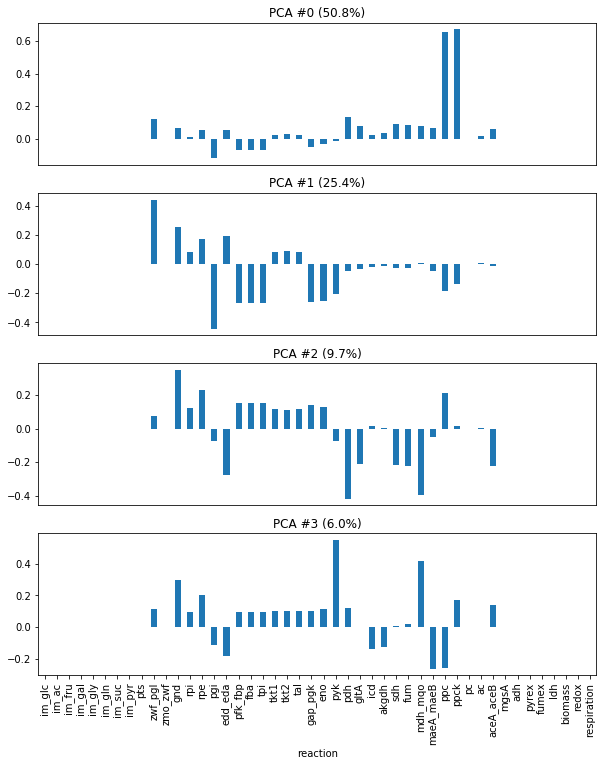

In [10]:
fig, axs = plt.subplots(n_components, 1, figsize=(10, n_components * 3))
for i, ax in enumerate(axs.flat):
    decomp_df[col_names[i]].plot.bar(ax=ax)
    ax.set_title(col_names[i])
    if (i < n_components - 1):
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel('')

proj_meas = fca.rel_flux_df.dot(decomp_df)
proj_meas = proj_meas.reset_index().join(fca.meta_df, on='serial_number')

sources = proj_meas['original source'].unique()
cmap = dict(zip(sources, sns.color_palette("muted", n_colors=len(sources))))

### plot a sorted bar plot of the measured data according to the 4 PCs 

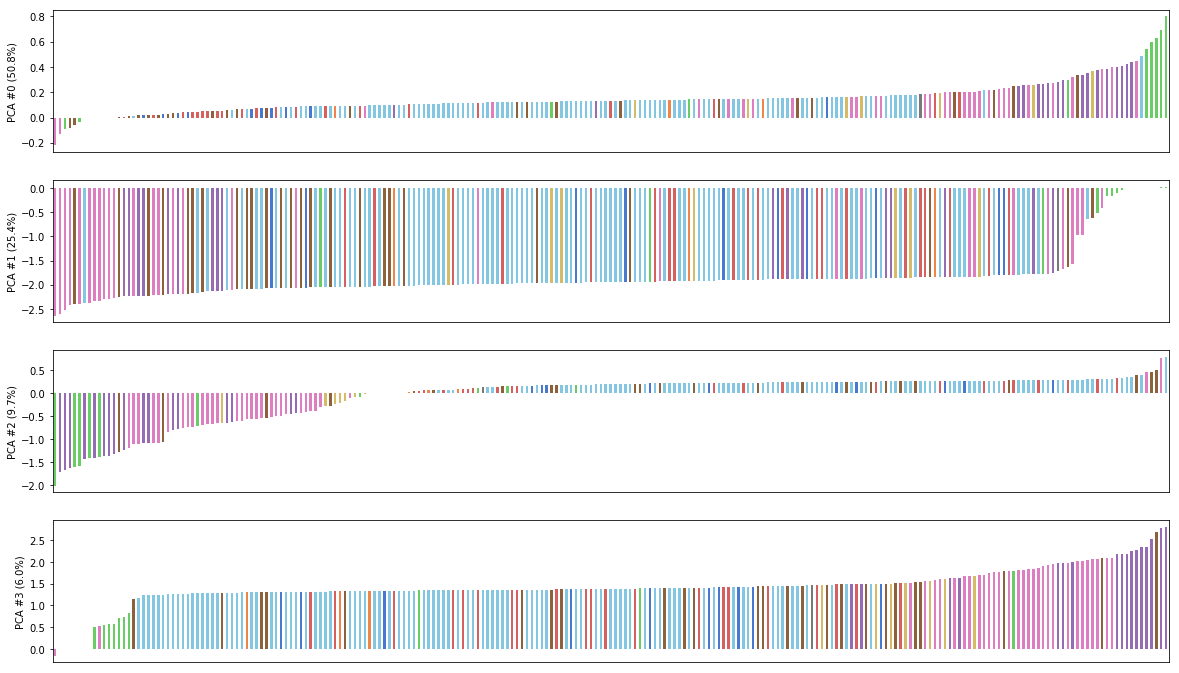

In [11]:
fig, axs = plt.subplots(n_components, 1, figsize=(20, n_components * 3))
for i, ax in enumerate(axs.flat):
    _data = proj_meas.copy()
    _data.sort_values(col_names[i], inplace=True)
    _data[col_names[i]].apply(nominal_value).plot.bar(
        ax=ax, color=_data['original source'].apply(cmap.get))
    ax.set_ylabel(col_names[i])
    ax.get_xaxis().set_ticks([])
    ax.set_xlabel('')    

### plot a scatter plot of the first two PCs of the measured data and overlay with a 2D KDE plot of the sampled data

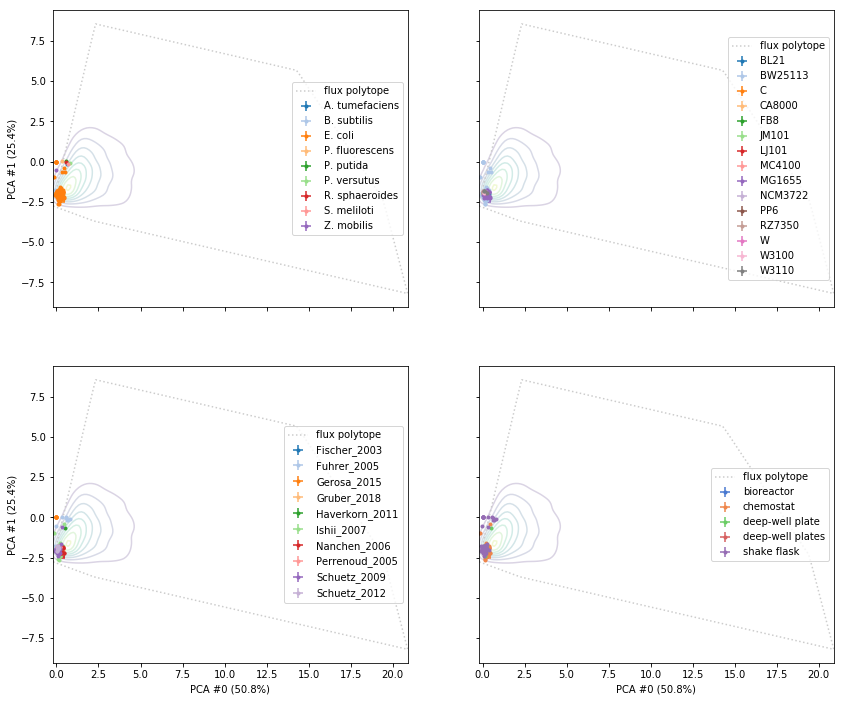

In [12]:
x_col, y_col = map(col_names.__getitem__, [0, 1])

fig, axs = FluxComponentAnalysis.PlotGroups(
    proj_meas, ['species', 'strain', 'original source', 'condition'],
    x_col=x_col, y_col=y_col)

proj_smpl = f_smpl.dot(decomp_df)
ppp = fsampler.phenotypic_phase_plane(decomp_df[x_col],
                                      decomp_df[y_col])
ppp.columns = [x_col, y_col]
for ax in axs.flat:
    sns.kdeplot(proj_smpl[x_col], proj_smpl[y_col], cmap='viridis',
                zorder=0, ax=ax, alpha=0.2)
    # ax.scatter(proj_smpl[x_col], proj_smpl[y_col],
    #           zorder=0, color=(0.9, 0.9, 0.9), alpha=0.5,
    #           label='FBA samples')
    ppp.plot(x=x_col, y=y_col, ax=ax, style=':',
             zorder=0, color=(0.8, 0.8, 0.8),
             label='flux polytope')
    ax.legend(loc='center right')

### second figure - each PC versus biomass

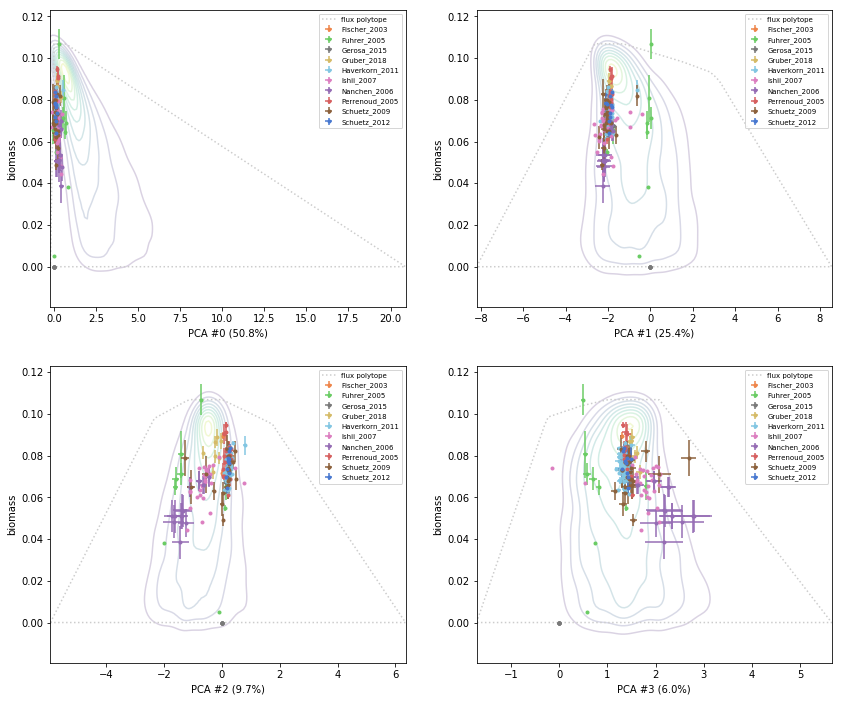

In [13]:
fca.TestBiomassFunction()

## Analyse Degrees Of Freedom

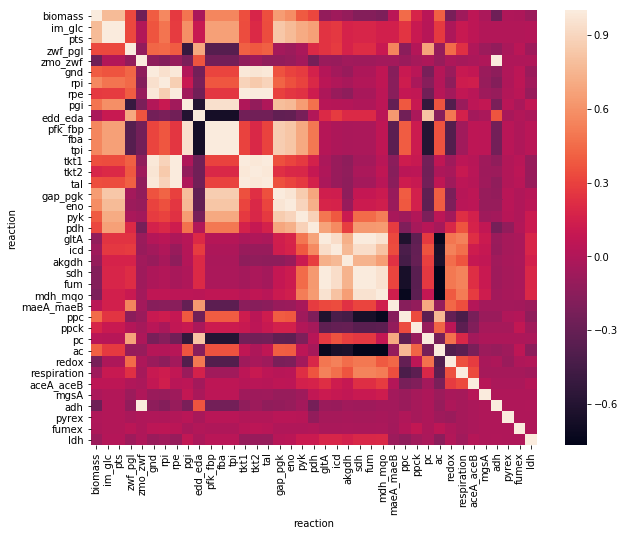

In [14]:
sources = fca.meta_df['original source'].unique()
cmap = dict(zip(sources, sns.color_palette("muted", n_colors=len(sources))))

Nd = fca.dof_df.shape[1]
# plot a histogram for each DOF
fig, axs = plt.subplots(Nd, 1, figsize=(20, Nd * 3))
for (col, ser), ax in zip(fca.dof_df.T.iterrows(), axs.flat):
    ser = ser.apply(lambda x: x.magnitude).apply(nominal_value).sort_values()
    color = fca.meta_df.loc[ser.index, 'original source'].apply(cmap.get)
    ser.plot.bar(ax=ax, color=color)
    ax.set_ylabel(col) 

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2530 RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2531 RuntimeWarning: invalid value encountered in true_divide


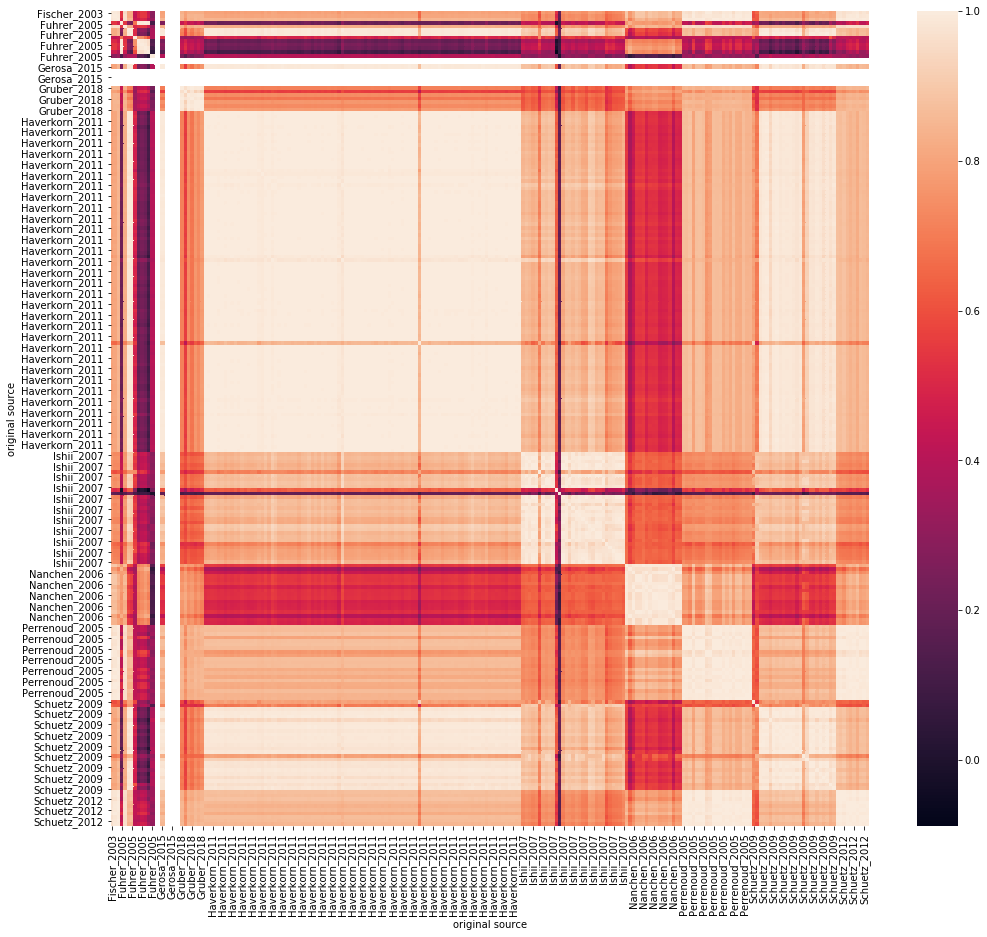

In [15]:
#        fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
#        for ax, groupbycol, pal in zip(axs.flat[0:4],
#                                       ['species', 'strain', 'original source', 'condition'],
#                                       ["tab20", "tab20", "muted", "muted"]):
#            groups = dof_meta_df.groupby(groupbycol)
#            cmap = sns.color_palette(pal, n_colors=len(groups))
#
#            for i, (gr_name, gr) in enumerate(groups):
#                ax.errorbar(gr[dim1].apply(F_NOM),
#                            gr[dim2].apply(F_NOM),
#                            xerr=gr[dim1].apply(F_STD),
#                            yerr=gr[dim2].apply(F_STD),
#                            c=cmap[i], label=gr_name, zorder=2, fmt='.')
#
#            ax.legend(fontsize=7, loc='best', title=groupbycol)
#        axs[0, 0].set_ylabel(dim2, fontsize=12)
#        axs[1, 0].set_ylabel(dim2, fontsize=12)
#        axs[1, 0].set_xlabel(dim1, fontsize=12)
#        axs[1, 1].set_xlabel(dim1, fontsize=12)
#        fig.savefig('../res/dof.pdf')

In [ ]:
dof_meta_df = fca.dof_df.reset_index().join(self.meta_df, on='serial_number')

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for ax, groupbycol, pal in zip(axs.flat[0:4],
                               ['species', 'strain', 'original source', 'condition'],
                               ["tab20", "tab20", "muted", "muted"]):
    groups = dof_meta_df.groupby(groupbycol)
    cmap = sns.color_palette(pal, n_colors=len(groups))

    for i, (gr_name, gr) in enumerate(groups):
        ax.errorbar(gr[dim1].apply(nominal_value),
                    gr[dim2].apply(nominal_value),
                    xerr=gr[dim1].apply(std_dev),
                    yerr=gr[dim2].apply(std_dev),
                    c=cmap[i], label=gr_name, zorder=2, fmt='.')

    ax.legend(fontsize=7, loc='best', title=groupbycol)
axs[0, 0].set_ylabel(dim2, fontsize=12)
axs[1, 0].set_ylabel(dim2, fontsize=12)
axs[1, 0].set_xlabel(dim1, fontsize=12)
axs[1, 1].set_xlabel(dim1, fontsize=12)

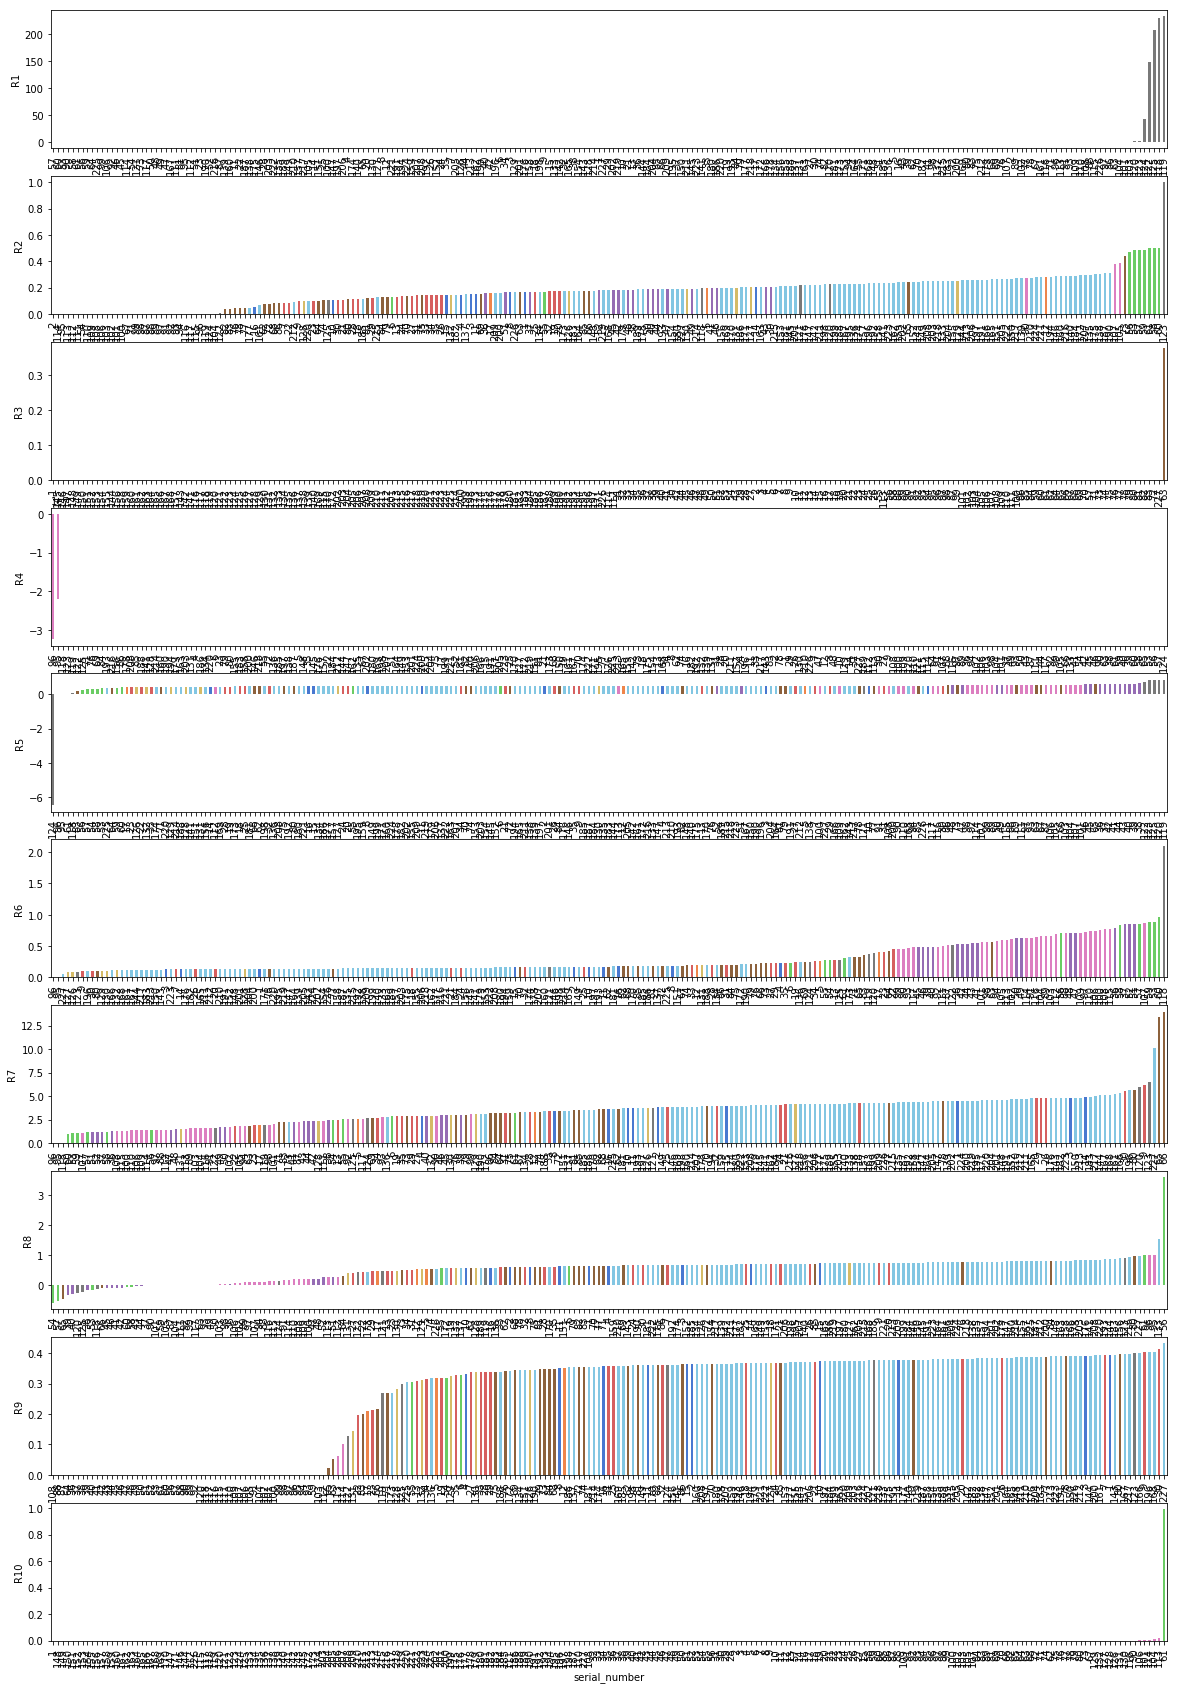

In [16]:
sources = fca.meta_df['original source'].unique()
cmap = dict(zip(sources, sns.color_palette("muted", n_colors=len(sources))))

Nd = fca.dof_df.shape[1]
# plot a histogram for each DOF
fig, axs = plt.subplots(Nd, 1, figsize=(20, Nd * 3))
for (col, ser), ax in zip(fca.dof_df.T.iterrows(), axs.flat):
    ser = ser.apply(lambda x: x.magnitude).apply(nominal_value).sort_values()
    color = fca.meta_df.loc[ser.index, 'original source'].apply(cmap.get)
    ser.plot.bar(ax=ax, color=color)
    ax.set_ylabel(col)